# Séance 1 - Réseau dense : Proposition de correction

Ce notebook est une proposition de correction pour le TP de la séance 1. Un travail différent peut être correct sans pour autant être identique à celui-là.

Commençons par importer l'ensemble des éléments dont nous aurons besoin.

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


mnist = keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = (mnist.load_data())
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, train_size=0.8)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_valid = scaler.transform(X_valid.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_test = scaler.transform(X_test.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)

## Sujet C - Une première méthode de régularisation

L'objectif est de comparer plusieurs réseaux de neurones selon différentes *force* de régularisation. Nous allons comparer un réseau de neurone sans régularisation, puis avec une régularisation modérée et forte.

La régularisation $\mathcal{L}_2$ est appliqué couche par couche dans un réseau de neurones, et non au niveau global du réseau. Ainsi, nous pouvons spécifier des valeurs différentes pour chaque couche si on le souhaite.

Nous ferons le choix d'appliquer pour chaque couche la même valeur de régularisation, sauf à la couche d'output.

In [2]:
def design_and_train(learning_rate, n_epochs, regularization, verbose=1):
  regularizer = keras.regularizers.L2(l2=regularization)
  model = keras.models.Sequential([
      keras.layers.Flatten(input_shape=[28, 28]),
      keras.layers.Dense(528, activation="relu", kernel_initializer="he_normal", kernel_regularizer=regularizer),
      keras.layers.Dense(256, activation="relu", kernel_initializer="he_normal", kernel_regularizer=regularizer),
      keras.layers.Dense(256, activation="relu", kernel_initializer="he_normal", kernel_regularizer=regularizer),
      keras.layers.Dense(256, activation="relu", kernel_initializer="he_normal", kernel_regularizer=regularizer),
      keras.layers.Dense(10, activation="softmax", kernel_initializer="he_normal")
    ])
  model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=learning_rate), metrics=["accuracy"])
  history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=32, validation_data=(X_valid, y_valid), verbose=verbose)
  return history

Nous allons mesurer pour quatre valeurs de $\lambda$ différente l'impact de la régularisation $\mathcal{L}_2$ sur le réseau de neurones.
On s'attend à ce qu'une régularisation forte réduise l'overfitting au prix d'une performance un peu plus faible.

In [3]:
learning_rate = 1e-3
n_epochs = 100

results = []

for regularization in [0, 0.001, 0.01, 0.1]:
  print("Regularization : %0.3f" % regularization)
  history = design_and_train(learning_rate, n_epochs, regularization, verbose=0)
  result = {"regularization": regularization, "history": history}
  results.append(result)

Regularization : 0.000
Regularization : 0.001
Regularization : 0.010
Regularization : 0.100


Il ne nous reste plus qu'à visualiser les courbes de performances:

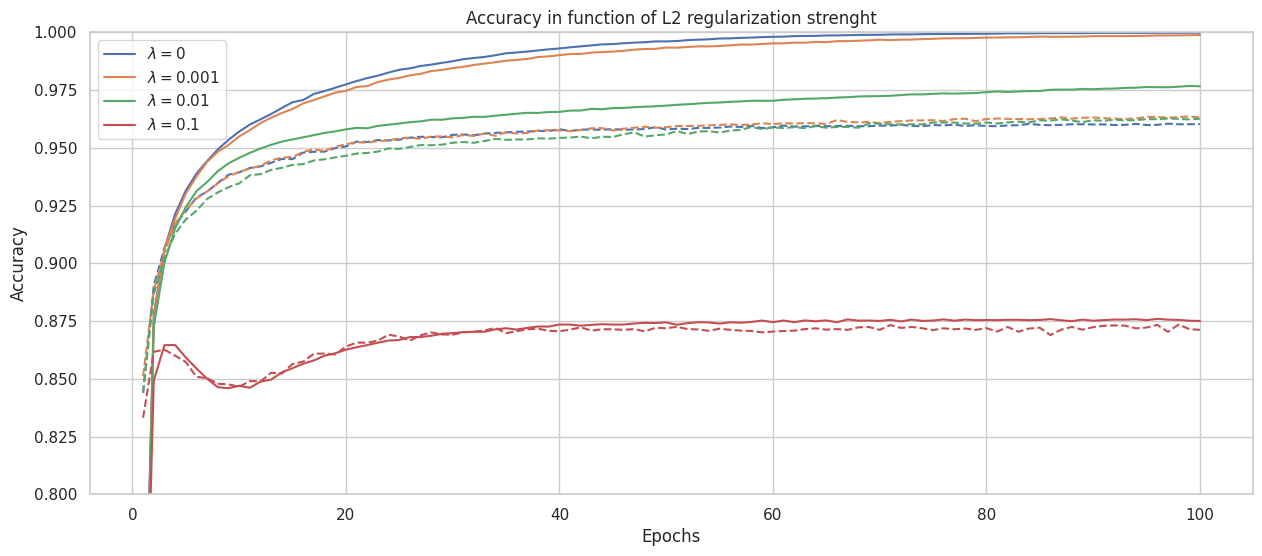

In [8]:
plt.figure(figsize=(15, 6))
epochs = range(1, n_epochs+1)
for index, result in enumerate(results):
  color = sns.color_palette()[index]
  historic = result["history"].history
  label = r"$\lambda = $" + str(result["regularization"])
  plt.plot(epochs, np.array(historic["accuracy"]), label=label, color=color)
  plt.plot(epochs, np.array(historic["val_accuracy"]),  '--', color=color)
  plt.title("Accuracy in function of L2 regularization strenght")
  plt.ylim(0.8, 1)
  plt.ylabel("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

plt.show()

Comme attendu, la régularisation la plus forte a la moins bonne performance et elle ne semble pas s'améliorer. Cependant, il n'y a pas eu d'over-fitting.

La meilleurs courbes d'apprentissage est la courbe pour $\lambda = 0.01$ : on a une bonne accuracy sans pour autant avoir un écart entre la courbe d'entraînement et de validation. Elle semble d'ailleurs encore pouvoir s'améliorer.

Voyons les courbes pour la loss.

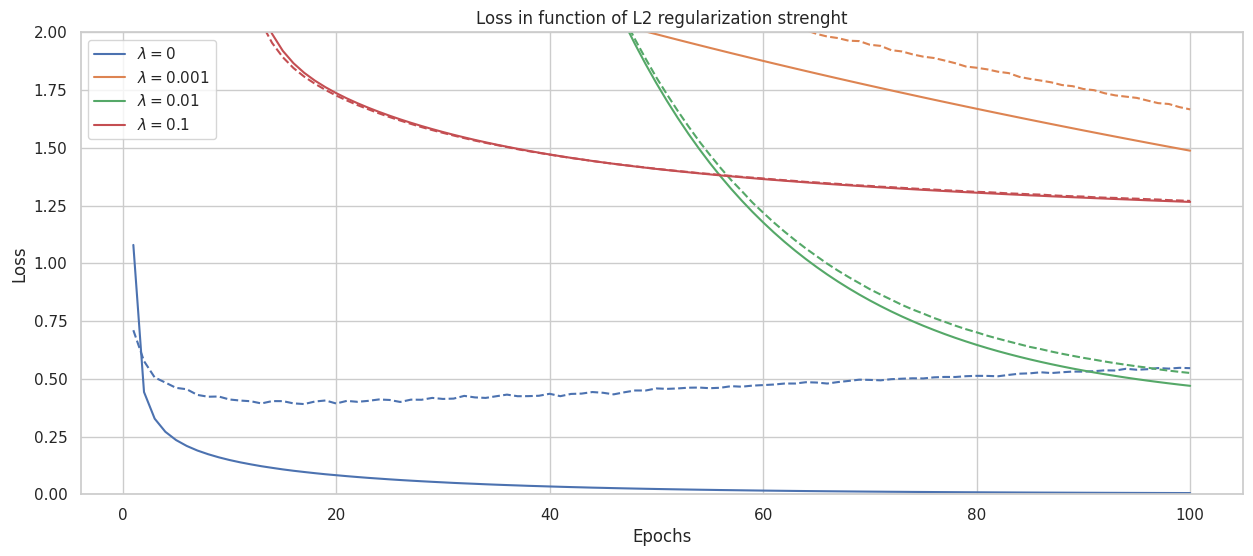

In [9]:
plt.figure(figsize=(15, 6))
epochs = range(1, n_epochs+1)
for index, result in enumerate(results):
  color = sns.color_palette()[index]
  historic = result["history"].history
  label = r"$\lambda = $" + str(result["regularization"])
  plt.plot(epochs, np.array(historic["loss"]), label=label, color=color)
  plt.plot(epochs, np.array(historic["val_loss"]),  '--', color=color)
  plt.title("Loss in function of L2 regularization strenght")
  plt.ylim(0, 2)
  plt.ylabel("Loss")
  plt.xlabel("Epochs")
  plt.legend()

plt.show()

Nous avons un sur-apprentissage net quand il n'y a pas de régularisation. Inversement, pour la régularisation la plus forte, le réseau ne progresse plus mais n'a pas sur-appris.

Pour les deux autres courbes d'apprentissages, nous ne sommes pas arrivé encore dans la fin de l'apprentissage.

Pour la suite, on peut conserver $\lambda = 0.01$ et prolonger l'apprentissage.